In [1]:
import pandas as pd 
import numpy as np

import pandas_profiling

from scipy.stats import norm
from sklearn.linear_model import LinearRegression

import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt 

# Running R from Python usin rpy2:
import rpy2.robjects as ro 
from rpy2.robjects import pandas2ri # pandas dataframe to r dataframe
# if necessary we can load packages from R here as well using importr
pandas2ri.activate()


In [2]:
data = pd.read_csv('D:/Phillip/GitHub/Datasets/Pseudo Poisson Maximum Likelihood/Windenergie_Hochrechnung_2019_2020_CSV.csv', sep = ';', parse_dates = ['Date'], decimal = ',')
data.head()
# energy production columns contains zeroes - could also sum to hourly data to create the larger spread of values for the log transformation

,Date,From,To,50Hertz (MW),Amprion (MW),TenneT TSO (MW),TransnetBW (MW)
0,23082019,00:00:00,00:15:00,74.0,5.0,9.68,1.44
1,23082019,00:15:00,00:30:00,73.0,5.0,10.16,1.38
2,23082019,00:30:00,00:45:00,63.0,6.0,10.94,1.38
3,23082019,00:45:00,01:00:00,55.0,7.0,11.39,1.50
4,23082019,01:00:00,01:15:00,54.0,6.0,12.09,1.77


In [12]:
print(data.shape) # 38112
print(data.dtypes)

(38112, 7)
Date                object
From                object
To                  object
50Hertz (MW)       float64
Amprion (MW)       float64
TenneT TSO (MW)    float64
TransnetBW (MW)    float64
dtype: object


In [13]:
pandas_profiling.ProfileReport(data)

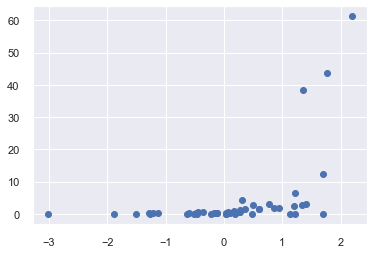

In [25]:
# 1. Simulated Example:
n = 50

X = norm.rvs(loc = 0, scale = 1, size = n) # std dev = 4
B0 = -1.0
B1 = 2.0
U = norm.rvs(loc = 0, scale = 1, size = n)

Y = np.zeros(n)
for i in range(n):
    if U[i] >= -0.7:
        Y[i] = np.exp(B0 + B1*X[i] + U[i])

plt.scatter(X, Y)


In [7]:
np.where(Y < 0.0000001)

(array([ 5,  6,  9, 13, 16, 32, 34, 36, 39, 46, 49], dtype=int64),)

In [26]:
data = {'Y' : Y, 'X' : X}
df = pd.DataFrame(data)
#df.to_csv("D:/Phillip/GitHub/Datasets/Pseudo Poisson Maximum Likelihood/Data.csv")

In [27]:
delta1 = 1
df['logY_delta1'] = np.log(df['Y'] + delta1) # take log of Y plus a constant to avoid log of zero 
delta2 = 0.001
df['logY_delta01'] = np.log(df['Y'] + delta2) # take log of Y plus a constant to avoid log of zero 
df.head(3)

,Y,X,logY_delta1,logY_delta01
0,1.763060,0.944334,1.016339,0.567618
1,0.652325,0.260389,0.502184,-0.425680
2,2.333093,1.203743,1.203901,0.847623


In [28]:
# OLS:
ols1 = LinearRegression().fit(df['X'].values.reshape(-1, 1), df['logY_delta1'].values.reshape(-1,1))
print(ols1.intercept_, ols1.coef_)

ols2 = LinearRegression().fit(df['X'].values.reshape(-1, 1), df['logY_delta01'].values.reshape(-1,1))
print(ols2.intercept_, ols2.coef_)



[0.61497108] [[0.6369064]]
[-1.90586244] [[1.43219738]]


In [12]:
ols1.coef_[0][0]

0.46903359668288136

In [29]:
# PPML: 
model_ppml = ro.r.glm('Y ~ X', data = df, family = ro.r('quasipoisson(link="log")'))
# print(ro.r.summary(model_ppml)) # why does it print so much information? Scroll to bottom to see actual model summary. 
print(model_ppml.rx2('coefficients'))


[-0.93487305  2.29775669]


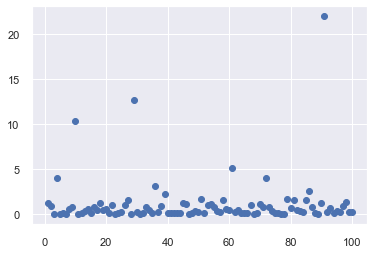

In [2]:
# Example from Paper:
n = 100

X1 = norm.rvs(loc = 0, scale = 1, size = n) # std dev = 1
X2 = norm.rvs(loc = 0, scale = 1, size = n) # std dev = 1
B0 = -1.0
B1 = 0.5
B2 = 1.5
U = norm.rvs(loc = 0, scale = .1, size = n)

Y = np.zeros(n)
Y0 = np.zeros(n)
for i in range(n):
    if U[i] >= -0.7:
        Y[i] = np.exp(B0 + B1*X1[i] + B2*X2[i] + U[i])
    Y0[i] = B0 + B1*X1[i] + B2*X2[i] + U[i]

plt.scatter(np.linspace(1, n, n), Y)

data = {'Y' : Y, 'Y0' : Y0, 'X1' : X1, 'X2' : X2}
df = pd.DataFrame(data)
#df.to_csv("D:/Phillip/GitHub/Datasets/Pseudo Poisson Maximum Likelihood/Data.csv")



In [3]:
# OLS:

ols0 = LinearRegression().fit(df[['X1', 'X2']], df['Y0'].values.reshape(-1,1))
print(ols0.intercept_, ols0.coef_) # coefficient estimates are very good

delta = 1
df['logY'] = np.log(df['Y'] + delta) # take log of Y plus a constant to avoid log of zero 
ols = LinearRegression().fit(df[['X1', 'X2']], df['logY'].values.reshape(-1,1))
print(ols.intercept_, ols.coef_) # coefficient estimates are quite poor. 

delta = .01
df['logY'] = np.log(df['Y'] + delta) # take log of Y plus a constant to avoid log of zero 
ols_s = LinearRegression().fit(df[['X1', 'X2']], df['logY'].values.reshape(-1,1))
print(ols_s.intercept_, ols_s.coef_) # coefficient estimates are quite good now the delta is much smaller

[-0.9854179] [[0.51050079 1.5013082 ]]
[0.52739373] [[0.1587914  0.46876118]]
[-0.91405512] [[0.47704461 1.40873044]]


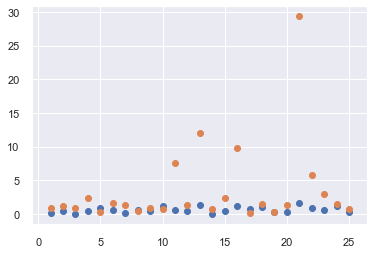

In [9]:
residual = np.zeros(n)
Yhat = np.zeros(n)
for i in range(n):    
    Yhat[i] = ols.predict(df.iloc[i, :][['X1', 'X2']].values.reshape(1, -1))
    residual[i] = (df.iloc[i, :]['Y'] - np.exp(Yhat[i])) ** 2

plt.scatter(np.linspace(1, n, n), Yhat)
plt.scatter(np.linspace(1, n, n), residual)

In [13]:
# PPML: we don't need to convert to an r dataframe anymore, this seems to happen upon calling the function. 
model_ppml = ro.r.glm('Y ~ X1 + X2', data = df, family = ro.r('quasipoisson(link="log")'))
# print(ro.r.summary(model_ppml)) # why does it print so much information? Scroll to bottom to see actual model summary. 
print(model_ppml.rx2('coefficients'))
#Coefficients: from summary output
#             Estimate Std. Error t value Pr(>|t|)    
#(Intercept) -1.004876   0.016642  -60.38   <2e-16 ***
#X1           0.524954   0.009696   54.14   <2e-16 ***
#X2           1.529290   0.009656  158.38   <2e-16 ***

# Parameter estimates are very good. Better than adding delta = 1 or 0.01

[-1.00487611  0.52495438  1.52928964]


In [7]:
# Can we reproduce the bias results for changing n? Or changing delta (in y + delta)? Result is a plot from monte carlo simulation over a grid of values.
# Table of average (standard deviation for certain values) These would be for the OLS version only (the plots). 

# Vary delta with fixed n:
n = 50
B0 = -1.0
B1 = 2.0
delta_list = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]

M = 250 # monte carlo simulation size
B1_hat = np.zeros(shape = (len(delta_list), M)) # we want to calculate the mean and standard error at each delta in delta_list

for m in range(M):
    Y = np.zeros(n)
    X = norm.rvs(loc = 0, scale = 1, size = n) # std dev = 1
    U = norm.rvs(loc = 0, scale = 1, size = n) #std dev = 1
    for i in range(n):
        if U[i] >= -0.7:
            Y[i] = np.exp(B0 + B1*X[i] + U[i])

    data = {'Y' : Y, 'X' : X}
    df = pd.DataFrame(data)

    for ix, delta in enumerate(delta_list):
        df['logY_delta'] = np.log(df['Y'] + delta) # take log of Y plus a constant to avoid log of zero 
        ols1 = LinearRegression().fit(df['X'].values.reshape(-1, 1), df['logY_delta'].values.reshape(-1,1))
        B1_hat[ix][m] = ols1.coef_[0][0] # extract the numnber from the ndarray


# Output the mean and standard error of each row in the ndarray:
delta_mean = np.mean(B1_hat, axis = 1) # axis = 1 takes the mean of each row (imagining as a matrix)
delta_std = np.std(B1_hat, axis = 1) # deviation of the monte carlo estimate - not the standard error of the coefficient estimate from the ols.
print(delta_mean, delta_std)

[1.50734175 1.50780591 1.50735481 1.50137178 1.49402056 1.44924244
 1.40908501 1.2373024  1.12450508 0.79362151 0.64069133] [0.72159953 0.62405264 0.582702   0.48928309 0.45074234 0.36754004
 0.33527004 0.26986302 0.24495841 0.18938142 0.16537536]


In [4]:
delta_list

array([1.00000000e-04, 5.27263158e-02, 1.05352632e-01, 1.57978947e-01,
       2.10605263e-01, 2.63231579e-01, 3.15857895e-01, 3.68484211e-01,
       4.21110526e-01, 4.73736842e-01, 5.26363158e-01, 5.78989474e-01,
       6.31615789e-01, 6.84242105e-01, 7.36868421e-01, 7.89494737e-01,
       8.42121053e-01, 8.94747368e-01, 9.47373684e-01, 1.00000000e+00])

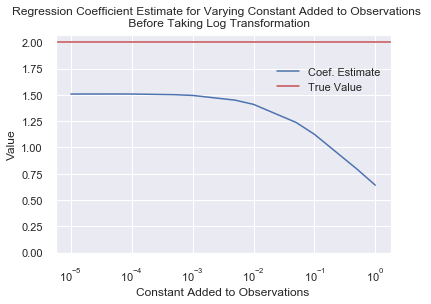

In [14]:
# Plot the mean and standard error bars at each delta in delta_list:
fig1, ax1 = plt.subplots()
fig1.suptitle('Regression Coefficient Estimate for Varying Constant Added to Observations \n Before Taking Log Transformation')
ax1.plot(delta_list, delta_mean, label = 'Coef. Estimate')
ax1.axhline(y=B1, color='r', linestyle='-', label = 'True Value')
ax1.set_ylim(ymin = 0)
ax1.set_xscale('log')
ax1.set_xlabel('Constant Added to Observations')
ax1.set_ylabel('Value')
ax1.legend(loc='upper right', bbox_to_anchor=(1.0, 0.9))
fig1.savefig('D:/Phillip/GitHub/Datasets/Pseudo Poisson Maximum Likelihood/CoefficientBias_withDelta.png', bbox_inches='tight')

In [2]:
# Vary n with fixed delta:

n_list = [10, 30, 50, 75, 100]
B0 = -1.0
B1 = 2.0
delta = 0.0001
M = 250 # monte carlo simulation size
B1_hat_ols = np.zeros(shape = (len(n_list), M)) # we want to calculate the mean and standard error at each delta in delta_list
B1_hat_ppml = np.zeros(shape = (len(n_list), M))


for m in range(M):
    for idx, n in enumerate(n_list):
            Y = np.zeros(n)
            X = norm.rvs(loc = 0, scale = 1, size = n) # std dev = 1
            U = norm.rvs(loc = 0, scale = 1, size = n) #std dev = 1
            for i in range(n):
                if U[i] >= -0.7:
                    Y[i] = np.exp(B0 + B1*X[i] + U[i])

            data = {'Y' : Y, 'X' : X}
            df = pd.DataFrame(data)
    
            df['logY_delta'] = np.log(df['Y'] + delta) # take log of Y plus a constant to avoid log of zero 
            ols1 = LinearRegression().fit(df['X'].values.reshape(-1, 1), df['logY_delta'].values.reshape(-1,1))
            B1_hat_ols[idx][m] = ols1.coef_[0][0] # extract the numnber from the ndarray

            model_ppml = ro.r.glm('Y ~ X', data = df, family = ro.r('quasipoisson(link="log")'))
            B1_hat_ppml[idx][m] = model_ppml.rx2('coefficients')[1]


# Output the mean and standard error of each row in the ndarray:
ols_mean = np.mean(B1_hat_ols, axis = 1) # axis = 1 takes the mean of each row (imagining as a matrix)
ols_std = np.std(B1_hat_ols, axis = 1) # deviation of the monte carlo estimate - not the standard error of the coefficient estimate from the ols.
print(ols_mean, ols_std)

ppml_mean = np.mean(B1_hat_ppml, axis = 1) # axis = 1 takes the mean of each row (imagining as a matrix)
ppml_std = np.std(B1_hat_ppml, axis = 1) # deviation of the monte carlo estimate - not the standard error of the coefficient estimate from the ols.
print(ppml_mean, ppml_std)


[1.48520874 1.52172801 1.50430375 1.46675714 1.52570894] [1.49258527 0.78721316 0.57605499 0.46973761 0.40551347]
[1.88188791 1.87880535 1.93207154 1.90081791 1.92497907] [1.04960067 0.63048535 0.62254104 0.42471296 0.46143093]


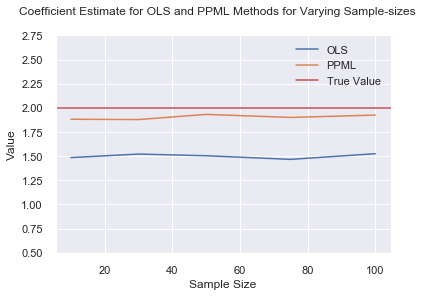

In [3]:
# Plot the mean and standard error bars at each sample size for both methods:
fig1, ax1 = plt.subplots()
fig1.suptitle('Coefficient Estimate for OLS and PPML Methods for Varying Sample-sizes')
ax1.plot(n_list, ols_mean, label = 'OLS')
ax1.plot(n_list, ppml_mean, label = 'PPML')
ax1.axhline(y=B1, color='r', linestyle='-', label = 'True Value')
ax1.set_ylim(0.5, 2.75)
ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Value')
ax1.legend(loc='upper right')
fig1.savefig('D:/Phillip/GitHub/Datasets/Pseudo Poisson Maximum Likelihood/CoefficientBias_samplesize.png', bbox_inches='tight')

In [3]:
# 2. Real Data Example:
data['Hour'] = data['From'].apply(lambda x : x[:2]) # first two characters in string are the hour of the start of each interval 
data = data.groupby(['Date', 'Hour'], as_index = False)[['50Hertz (MW)', 'Amprion (MW)']].sum()
data.head()

,Date,Hour,50Hertz (MW),Amprion (MW)
0,10012020,00,957.0,926.0
1,10012020,01,984.0,997.0
2,10012020,02,994.0,975.0
3,10012020,03,1123.0,945.0
4,10012020,04,1288.0,893.0


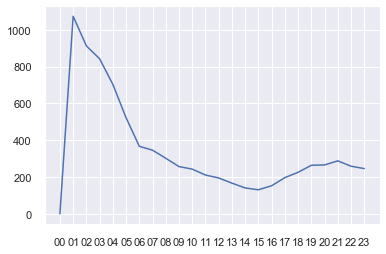

In [53]:
plt.plot(data.loc[data['Date'] == '27102019']['Hour'], data.loc[data['Date'] == '27102019']['Amprion (MW)'])
# This has a zero in the measurements. 

In [52]:
data.loc[data['Amprion (MW)'] == 0.0]

,Date,Hour,50Hertz (MW),Amprion (MW)
6168,27102019,00,1589.0,0.0


In [4]:
data_to_fit = data.loc[data['Date'] == '27102019']

In [55]:
delta = 0.1
data_to_fit['log_delta'] = np.log(data_to_fit['Amprion (MW)'] + delta) # take log of Y plus a constant to avoid log of zero 

In [58]:
data_to_fit['Hour_int'] = data_to_fit['Hour'].astype(int)

In [63]:
data_to_fit['Hour_int_sq'] = data_to_fit['Hour_int'] ** 2
data_to_fit['Y'] = data_to_fit['Amprion (MW)']

In [64]:
data_to_fit.head()

,Date,Hour,50Hertz (MW),Amprion (MW),log_delta,Hour_int,Hour_int_sq,Y
6168,27102019,00,1589.0,0.0,-2.302585,0,0,0.0
6169,27102019,01,1596.0,1073.0,6.978307,1,1,1073.0
6170,27102019,02,1672.0,912.0,6.815750,2,4,912.0
6171,27102019,03,1747.0,842.0,6.735899,3,9,842.0
6172,27102019,04,1649.0,703.0,6.555499,4,16,703.0


In [65]:
ols = LinearRegression().fit(data_to_fit[['Hour_int', 'Hour_int_sq']], data_to_fit['log_delta'].values.reshape(-1,1))
print(ols.intercept_, ols.coef_) # coefficient estimates are quite poor. 

model_ppml = ro.r.glm('Y ~ Hour_int + Hour_int_sq', data = data_to_fit, family = ro.r('quasipoisson(link="log")'))
print(model_ppml.rx2('coefficients'))

[4.32117906] [[ 0.23012693 -0.00890019]]
[ 6.73538536e+00 -1.52459062e-01  4.25010456e-03]


In [ ]:
# Calculate yhat for both models:


# Plot residuals:


# Calculate MSE:


